# Forecasting Exercise

Data is about a seasonal time series of California Hospitality Industry Employees.

In [1]:
# Import libraries & data
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('HospitalityEmployees.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'
print(len(df))
print(df.head())

348
            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


So <tt>df</tt> has 348 records and one column. The data represents the number of employees in thousands of persons as monthly averages from January, 1990 to December 2018.

In [2]:
df.tail()

,Employees
Date,
2018-08-01,2019.1
2018-09-01,1992.5
2018-10-01,1984.3
2018-11-01,1990.1
2018-12-01,2000.2


### 1. Plot the source data

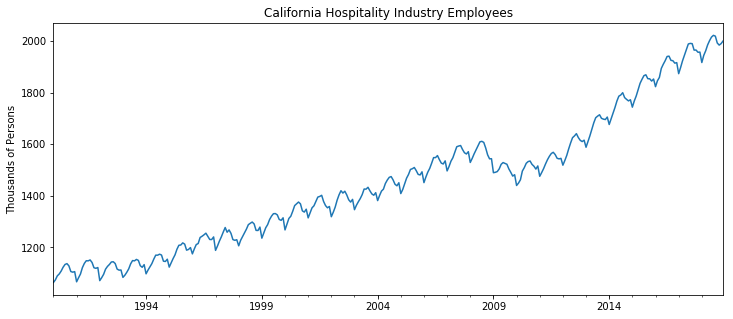

In [3]:
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel='' # we don't really need a label here

ax = df['Employees'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### 2. Run an ETS Decomposition
Use an 'additive' model.

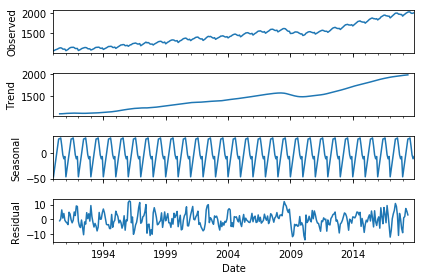

In [4]:
result = seasonal_decompose(df['Employees'], model='add')
result.plot();

### 3. Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot of combinations to evaluate.

In [5]:
auto_arima(df['Employees'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, 1, 12)   Log Likelihood               -1098.307
Date:                            Mon, 21 Oct 2019   AIC                           2210.614
Time:                                    00:00:52   BIC                           2237.559
Sample:                                         0   HQIC                          2221.343
                                            - 348                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.005      0.081      0.936      -0.010       0.011
ar.L1          0.9222      0.046     20.153      0.000       0.833       1.012
ma.L1         -0.9438      0.071    -13.367      0.000      -1.082      -0.805
ma.L2          0.1316      0.060      2.185      0.029       0.014       0.250
ar.S.L12       0.9977      0.001    722.847      0.000       0.995       1.000
ma.S.L12      -0.7574      0.042    -17.919      0.000      -0.840      -0.675
sigma2        29.1948      1.702     17.157      0.000      25.860      32.530
===================================================================================
Ljung-Box (Q):                       32.12   Jarque-Bera (JB):                66.33
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.09
Prob(H) (two-sided):                  0.45   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

You should see a recommended ARIMA Order of (1,1,2) combined with a seasonal order of (1,0,1,12).
These order might be different on different computing machine.
### 4. Split the data into train/test sets
Set one year (12 records) for testing.

In [6]:
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

### 5. Fit a SARIMA(1,1,2)(1,0,1,12) model to the training set

In [7]:
model = SARIMAX(train['Employees'],order=(1,1,2),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          Employees   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(1, 0, 1, 12)   Log Likelihood               -1058.058
Date:                            Mon, 21 Oct 2019   AIC                           2128.116
Time:                                    00:00:53   BIC                           2151.001
Sample:                                01-01-1990   HQIC                          2137.240
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9241      0.044     21.238      0.000       0.839       1.009
ma.L1         -0.9585      0.070    -13.619      0.000      -1.096      -0.821
ma.L2          0.1498      0.061      2.454      0.014       0.030       0.269
ar.S.L12       0.9973      0.001    730.121      0.000       0.995       1.000
ma.S.L12      -0.7519      0.044    -17.160      0.000      -0.838      -0.666
sigma2        28.7642      1.684     17.078      0.000      25.463      32.065
===================================================================================
Ljung-Box (Q):                       29.90   Jarque-Bera (JB):                73.32
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.17
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6. Obtain predicted values

In [8]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,2)(1,0,1,12) Predictions')

### 7. Plot predictions against known values

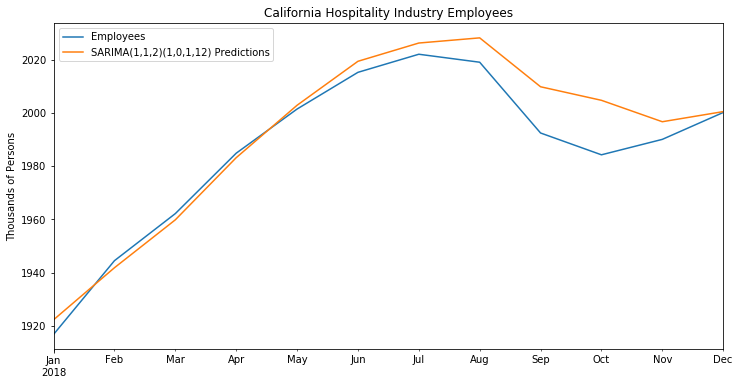

In [9]:
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = test['Employees'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### 8. Evaluate the Model using MSE and RMSE

In [10]:
error1 = mean_squared_error(test['Employees'], predictions)
error2 = rmse(test['Employees'], predictions)
print(f'SARIMA(1,1,2)(1,0,1,12) MSE Error: {error1:11.10}')
print(f'SARIMA(1,1,2)(1,0,1,12) RMSE Error: {error2:11.10}')

SARIMA(1,1,2)(1,0,1,12) MSE Error: 77.65505693
SARIMA(1,1,2)(1,0,1,12) RMSE Error: 8.812210672


### 9. Retrain the model on the full data and forecast one year into the future

In [11]:
model = SARIMAX(df['Employees'],order=(1,1,2),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(1,1,2)(1,0,1,12) Forecast')

### 10. Plot the forecasted values alongside the original data

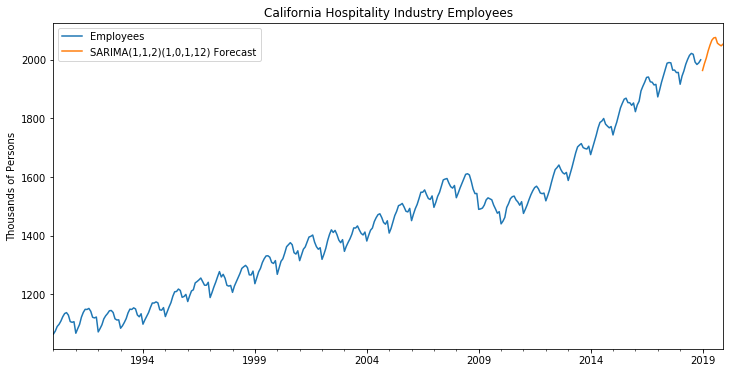

In [12]:
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = df['Employees'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);